# Run

In [1]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import copy
from tqdm import tqdm
import time
import os
from scipy import signal
from scipy.signal import find_peaks
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import pickle
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
with open('Udata.pkl', 'rb') as file:
    Udata = pickle.load(file)

# Vamos remover a atividade 'jumping'
actis = ['climbingdown', 'climbingup', 'lying', 'running', 'sitting', 'standing', 'walking']
posis = ['chest', 'forearm', 'head', 'shin', 'thigh', 'upperarm', 'waist']
users = ['proband' + x for x in np.arange(1,16).astype(str)]
# proband2 não tem acc_climbingup_forearm
users.remove('proband2')
# Vamos remover usuários com menos de 21000 amostras
users.remove('proband1')
users.remove('proband4')
users.remove('proband7')
users.remove('proband14')

# Funções

In [3]:
def getDI(ex, ey, printFLag=False, resaFlag=True):
    if resaFlag:
        nex = np.linspace(ex.min(), ex.max(), 10000)
        ney = np.interp(nex, ex, ey)
        ex, ey = nex, ney
    k = 30
    janela = 10
    faixa = (max(ex)-min(ex))/k
    score = []
    dim = []
    b = []
    for i in range(k-janela+1):
        limi = min(ex)+faixa*i
        lims = min(ex)+faixa*(i+janela)
        ni = np.argmin(abs(ex-limi))
        ns = np.argmin(abs(ex-lims))
        regre = LinearRegression().fit(ex[ni:ns].reshape(-1, 1), ey[ni:ns])
        dim.append(regre.coef_[0])
        b.append(regre.intercept_)
        score.append(regre.score(ex[ni:ns].reshape(-1, 1), ey[ni:ns]))
    i = np.argmax(score)
    if printFLag:
        limi = min(ex)+faixa*i
        lims = min(ex)+faixa*(i+janela)
        ni = np.argmin(abs(ex-limi))
        ns = np.argmin(abs(ex-lims))
        plt.plot(ex,ey)
        plt.plot([ex[ni], ex[ns]], np.array([ex[ni], ex[ns]])*dim[i]+b[i])
        plt.title('DI: '+str(dim[i].round(1)))
    return dim[i]

In [4]:
def getCR(X):
    N = X.shape[0]
    L = N*(N-1)//2
    rx = np.zeros(L)
    cont = 0
    for i in range(N-1):
        for j in range(i+1,N):
            rx[cont] = max(abs(X[i,:]-X[j,:]))*2
            cont += 1
    rx = np.sort(rx)
    rx = rx[rx>0]
    L = rx.shape[0]
    ex = np.log2(rx)
    ey = np.log2(np.arange(1,L+1)/L)
    return ex, ey

In [5]:
def getDI2(ex, ey, printFLag=False, resaFlag=True):
    if resaFlag:
        nex = np.linspace(ex.min(), ex.max(), 10000)
        ney = np.interp(nex, ex, ey)
        ex, ey = nex, ney
    k = 30
    janela = 10
    faixa = (max(ex)-min(ex))/k
    score = []
    dim = []
    b = []
    for i in range(k-janela+1):
        limi = min(ex)+faixa*i
        lims = min(ex)+faixa*(i+janela)
        ni = np.argmin(abs(ex-limi))
        ns = np.argmin(abs(ex-lims))
        regre = LinearRegression().fit(ex[ni:ns].reshape(-1, 1), ey[ni:ns])
        dim.append(regre.coef_[0])
        b.append(regre.intercept_)
        score.append(regre.score(ex[ni:ns].reshape(-1, 1), ey[ni:ns]))
    i = np.argmax(score)
    if printFLag:
        limi = min(ex)+faixa*i
        lims = min(ex)+faixa*(i+janela)
        ni = np.argmin(abs(ex-limi))
        ns = np.argmin(abs(ex-lims))
        plt.plot(ex,ey)
        plt.plot([ex[ni], ex[ns]], np.array([ex[ni], ex[ns]])*dim[i]+b[i])
    return dim, score

In [6]:
def getDI2(ex, ey, printFLag=False, resaFlag=True):
    if resaFlag:
        nex = np.linspace(ex.min(), ex.max(), 10000)
        ney = np.interp(nex, ex, ey)
        ex, ey = nex, ney
    k = 30
    janela = 10
    faixa = (max(ex)-min(ex))/k
    score = []
    dim = []
    b = []
    for i in range(15-janela+1):
        limi = min(ex)+faixa*i
        lims = min(ex)+faixa*(i+janela)
        ni = np.argmin(abs(ex-limi))
        ns = np.argmin(abs(ex-lims))
        regre = LinearRegression().fit(ex[ni:ns].reshape(-1, 1), ey[ni:ns])
        dim.append(regre.coef_[0])
        b.append(regre.intercept_)
        score.append(regre.score(ex[ni:ns].reshape(-1, 1), ey[ni:ns]))
    i = np.argmax(score)
    if printFLag:
        limi = min(ex)+faixa*i
        lims = min(ex)+faixa*(i+janela)
        ni = np.argmin(abs(ex-limi))
        ns = np.argmin(abs(ex-lims))
        plt.figure()
        plt.plot(ex,ey)
        plt.plot([ex[ni], ex[ns]], np.array([ex[ni], ex[ns]])*dim[i]+b[i])
        plt.title('DI: '+str(dim[i].round(1))+' Região: '+str(np.round(min(ex)+faixa*(i+janela/2), 1)))
        plt.show()
    return dim[i], min(ex)+faixa*(i+janela/2)

In [7]:
def getDIfix(ex, ey, printFLag=False, resaFlag=True):
    if resaFlag:
        nex = np.linspace(ex.min(), ex.max(), 10000)
        ney = np.interp(nex, ex, ey)
        ex, ey = nex, ney
    ni = np.sum(ex<-8)
    ns = np.sum(ex<-4)
    regre = LinearRegression().fit(ex[ni:ns].reshape(-1, 1), ey[ni:ns])
    dim = regre.coef_[0]
    b = regre.intercept_
    if printFLag:
        plt.figure()
        plt.plot(ex,ey)
        plt.plot([ex[ni], ex[ns]], np.array([ex[ni], ex[ns]])*dim+b)
        plt.title('DI: '+str(dim.round(1))+' Região: -6')
        plt.show()
    return dim

# Exps iniciais

In [8]:
nu = 0
Na = 21000
Ne = 3000
nd = 0
na = 0
X = np.array(Udata[nu][nd])[na, :, :3]/10
inds = np.random.permutation(Na)[:Ne]
ex, ey = getCR(X[inds])

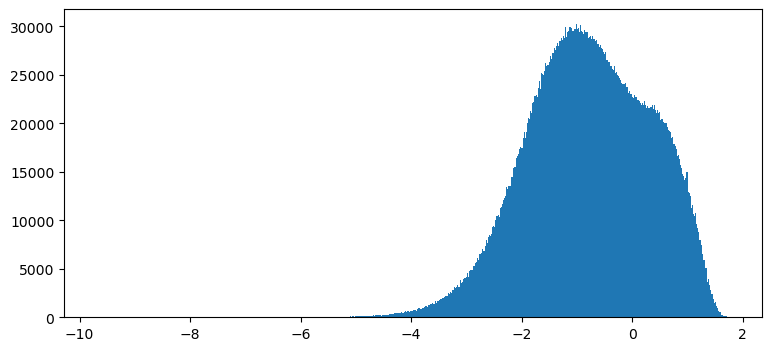

In [9]:
plt.figure(figsize=(9,4))
aux = plt.hist(ex, bins='auto')

In [14]:
np.sum(ex<-6)

674

In [10]:
np.sum(ex<-4)/ex.shape[0]

0.004037345781927309

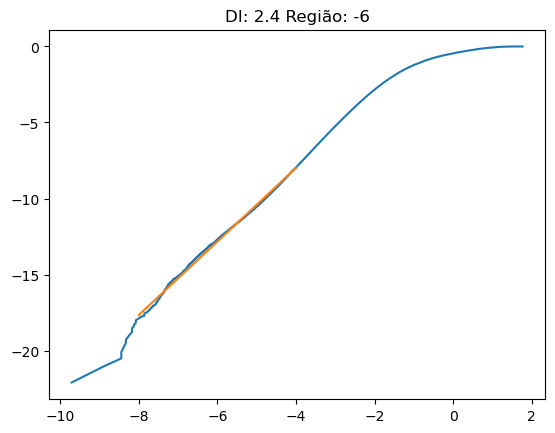

2.419331921757841

In [11]:
getDIfix(ex, ey, printFLag=True)

In [12]:
# Vamos encontras os k vizinhos mais próximos de cada dado